Dataset: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#pipeline and sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler





*A random seed was set to maintain the same results everytime.* 

In [5]:
np.random.seed(42)

# Load Data

In [6]:
contra = pd.read_csv("contraceptive_for_students.csv")
contra.head(5)

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [7]:
contra.size

14730

# Attribute Information



1. Wife's age (numerical)
2. Wife's education (categorical) 1=low, 2, 3, 4=high
3. Husband's education (categorical) 1=low, 2, 3, 4=high
4. Number of children ever born (numerical)
5. Wife's religion (binary) 0=Non-Islam, 1=Islam
6. Wife's now working? (binary) 0=Yes, 1=No
7. Husband's occupation (categorical) 1, 2, 3, 4
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high
9. Media exposure (binary) 0=Good, 1=Not good
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term


# Data Cleaning

##### 1. Check for null values

In [9]:
pd.DataFrame(contra.isna().sum()).rename(columns = {0 : 'Number of Null Values'})

,Number of Null Values
wife_age,0
wife_education,0
husband_education,0
num_child,0
wife_religion,0
wife_work,0
husband_occupation,0
standard_living,0
media_exposure,0
contraceptive,0


*Based on the results above, there are no null values in the code. Therefore, there is no need to drop or impute any of the values.* 

In [10]:
contra['type'] = contra['contraceptive'].replace({1: 'No Use', 2: "Long Term", 3 : "Short Term"})

*Some of the features in the data such as num_child and wife_age are continuous valued features
with different units of measurement (children vs years).*

*Next we define a function to standardize these
features as well as a basic feature transformation matrix that applies the standardize function
to a specific subset of features, in this case, num_child and wife_age.* 

In [11]:
def standardize(data, with_std = True):
    scaler = preprocessing.StandardScaler(with_std = with_std)
    columns = data.columns
    df = pd.DataFrame(scaler.fit_transform(data))
    df.columns = columns
    return df

"""
Standarizes the columns passed in the argument.
"""
def phi0(X, columns):
    for column in columns:
        X[column] = standardize(X[[column]])[column]
    return X

##### 2. Categorical Data &  One Hot Encoding

*Much of the data represents categorical variables.*

*Categorical Features: wife education, wife_religion, wife_work, husband_occupation, standard_living, media_exposure.*

*The categorical features must be one hot encoded. Although many of the categorical features are ordinal, there is no effective way to accurately asess how the difference between deature values. For example, its impossible to tell how much better standard_living index of 1 is then 2.*

In [17]:
def design(X, featurize = phi0):
    X = X.copy()
    categorical = X.copy()[['wife_education', 'husband_education', 'husband_occupation',
       'standard_living']]
    other = contra[['wife_age', 'num_child', "wife_work", "media_exposure"]]
    #one hot encode the categorical data
    encoder = preprocessing.OneHotEncoder()
    one_hot = pd.DataFrame(encoder.fit_transform(categorical).toarray())
    ohe_columns = ["wife_edu1", "wife_edu2", "wife_edu3", "wife_edu4", "hus_edu1", "hus_edu2", "hus_edu3", "hus_edu4", 
           "hus_occ1", "hus_occ2", "hus_occ3", "hus_occ4", "std_living1", "std_living2", "std_living3", 
           "std_living4"]
    one_hot.columns = ohe_columns
    contra_clean = other.join(one_hot)
    return featurize(contra_clean, columns = ['wife_age', 'num_child'])

In [18]:
def design_with_religion(X, featurize = phi0):
    X = X.copy()
    categorical = X.copy()[['wife_education', 'husband_education', 'husband_occupation',
       'standard_living', 'wife_religion']]
    other = contra[['wife_age', 'num_child', "wife_work", "media_exposure"]]
    #one hot encode the categorical data
    encoder = preprocessing.OneHotEncoder()
    one_hot = pd.DataFrame(encoder.fit_transform(categorical).toarray())
    ohe_columns = ["wife_edu1", "wife_edu2", "wife_edu3", "wife_edu4", "hus_edu1", "hus_edu2", "hus_edu3", "hus_edu4", 
           "hus_occ1", "hus_occ2", "hus_occ3", "hus_occ4", "std_living1", "std_living2", "std_living3", 
           "std_living4", 'wife_religion1', 'wife_religion2']
    one_hot.columns = ohe_columns
    contra_clean = other.join(one_hot)
    return featurize(contra_clean, columns = ['wife_age', 'num_child'])

# EDA

#### 1. Countplot representing the number of samples in each class.

Text(0.5, 1.0, 'Number of Samples in Each Class')

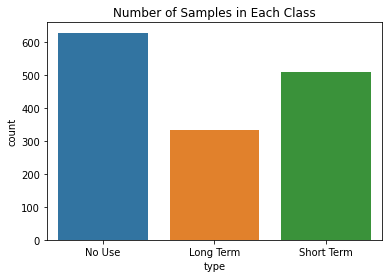

In [19]:
sns.countplot(data=contra, x = 'type')
plt.title("Number of Samples in Each Class")

*The above countplot shows that there was an unbalanced distribution of the data. Most of the data points belong to the "No Use" and "Short Term" contraceptive classes.*

#### 2. Correlation between Features

Text(0.5, 1.0, 'Heatmap of the given features')

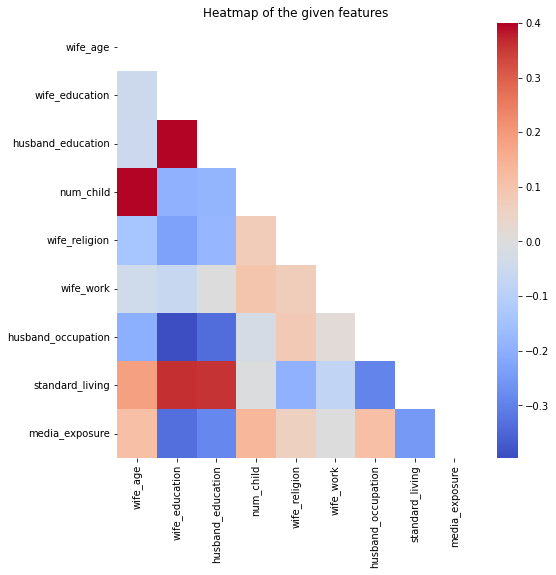

In [30]:
# Compute the correlation matrix
corr = contra.copy().drop(columns=['contraceptive']).corr()

#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.4, center=0).set_title("Correlation between features")
plt.title("Heatmap of the given features")

*A correlation heatmap was generated to compute the correlation coefficients of the features in the dataset. Based on the plot above, none of the features were highly correlated, so no features need to be dropped to avoid high variance*

#### 3. PCA

In [31]:
"""
Plots the prinicipal comonents vs their variance proportion
"""
def pca_plot(df, plot = 'scree', with_std = True):
    
    df_std = standardize(df.copy(), with_std)
    u, s, vt = np.linalg.svd(df_std, full_matrices=False)
    print(s)
    #pcs = df @ vt[:2].T
    pcs = df @ vt.T
    hues = contra['type']
    if plot == 'scree':
        plt.plot(range(1, len(s) + 1), s/sum(s))
        plt.xticks(range(1, len(s) + 1))
        plt.title("Proportion of Variance vs Principal Component #")
        plt.xlabel("Principal Component #")
        plt.ylabel("Proportion of Variance");
    elif plot == 'first':
        #project data to first pc and plot
        sns.stripplot(x = hues, y= pcs[0])
        plt.title("Strip Plot of Principal Component 1")
        plt.ylabel("PC 1 Value");
    elif plot == 'second':
        pcs = df @ vt[:2].T
        fig = sns.scatterplot(x = pcs[0], y = pcs[1], hue = hues, palette = 'coolwarm', legend = 'full')
        plt.xlabel("PC1")
        plt.ylabel("PC2");
    else:
        raise Exception("Plot type '{}' does not exist".format(plot))

*The plot below shows that the variance of the data is very spread out across principal components. It  appears  that  each  principal  component  contributes  only a small percentage of the variance in the data. Beacause of this dimensionality reduction would likely be a bad choice.*

[7.31390185e+01 5.53013797e+01 4.80966229e+01 4.72021749e+01
 4.55262977e+01 4.41844462e+01 4.13993919e+01 4.07851717e+01
 3.88043860e+01 3.85776122e+01 3.72189068e+01 3.60953909e+01
 3.33959790e+01 3.17158103e+01 2.69758085e+01 2.40384462e+01
 2.27393518e-14 2.06077576e-14 1.35807963e-14 9.79719801e-15]


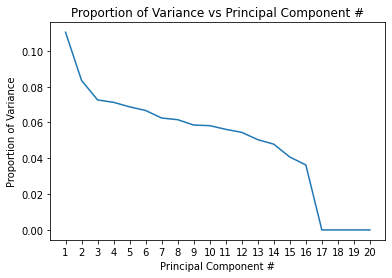

In [32]:
pca_plot(design(contra, phi0))

*The plot below is a strip plot of of the data projected on the first principal component.*

[7.31390185e+01 5.53013797e+01 4.80966229e+01 4.72021749e+01
 4.55262977e+01 4.41844462e+01 4.13993919e+01 4.07851717e+01
 3.88043860e+01 3.85776122e+01 3.72189068e+01 3.60953909e+01
 3.33959790e+01 3.17158103e+01 2.69758085e+01 2.40384462e+01
 2.27393518e-14 2.06077576e-14 1.35807963e-14 9.79719801e-15]


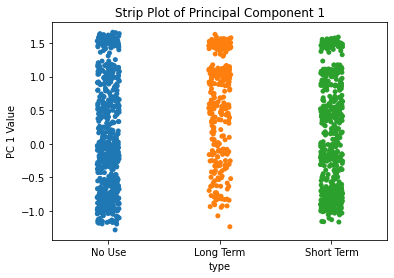

In [33]:
pca_plot(design(contra, phi0), 'first')

*The plot below shows the projection of the data on the first two principal components. Based on the plot, the variance in the data is widely spread. It is difficult to discern any sort of meaningful relationship between the projected data and the type of contraceptive used. This supports our previous claim that none of the features should be dropped.*

[7.31390185e+01 5.53013797e+01 4.80966229e+01 4.72021749e+01
 4.55262977e+01 4.41844462e+01 4.13993919e+01 4.07851717e+01
 3.88043860e+01 3.85776122e+01 3.72189068e+01 3.60953909e+01
 3.33959790e+01 3.17158103e+01 2.69758085e+01 2.40384462e+01
 2.27393518e-14 2.06077576e-14 1.35807963e-14 9.79719801e-15]


Text(0.5, 1.0, 'PCA using First 2 Principal Components')

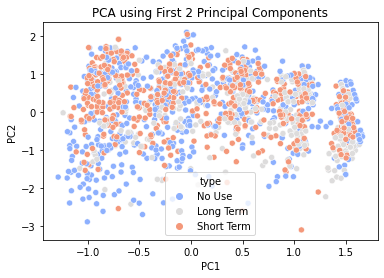

In [34]:
pca_plot(design(contra, phi0), "second")
plt.title("PCA using First 2 Principal Components")

#### 4. More Data Visualizations

*We were also interested in exploring the median age of the wife for all three classes.


*Analyzing the data below, it appears that the age median of women in "No use", "Long Term", "Short term", was 32, 35 and 29 respectively.*


Text(0.5, 1.0, 'Box Plot of Wife Age vs Contraceptive Method Used')

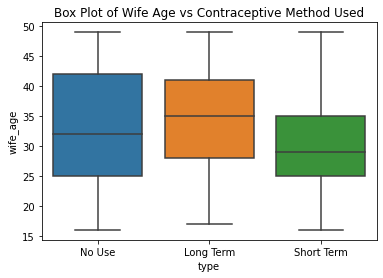

In [35]:
sns.boxplot(x = 'type', y = "wife_age", data = contra)
plt.title("Box Plot of Wife Age vs Contraceptive Method Used")

*The plot below shows the proportion of Muslim and Non Muslim women for each contraceptive class. It can be clearly interepreted from the plot that most of the data represents Muslim women. This indicated a selection bias in the data.*

*Because of this, it was decided to drop women's religion as a feature since it won't be helpful when designing the classification model. In other words, this feature won't give us any new information.*

Text(0.5, 1.0, 'Proportion of Muslim and Non Muslim Women for each Contraceptive Method Used')

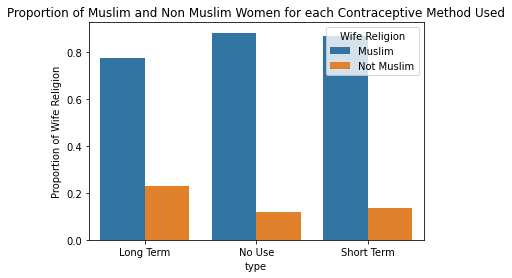

In [36]:
contra['Wife Religion'] = contra['wife_religion'].replace({0:"Not Muslim", 1 : "Muslim"})
def feature_percentage(feature):
    temp = contra.groupby(['type'])[feature].value_counts().groupby('type') \
        .apply(lambda x:  x / float(x.sum()))
    df = pd.DataFrame(temp)
    return df.rename(columns = {feature : "Proportion of " + feature}).reset_index()
df = feature_percentage("Wife Religion")
sns.barplot(x = "type", y = "Proportion of Wife Religion",  hue = "Wife Religion", data = df)
plt.title("Proportion of Muslim and Non Muslim Women for each Contraceptive Method Used")

*The plots below shows the proportion of the husband's education, wife's education and standard of living in each contraceptive class respectively.*

*It was was inferred from this plot that these features are extremely similar to one another in the "No Use" and "Short Term" class. This gives us the possibility of collapsing "No Use" and "Short Term" to one class.* 

Text(0.5, 1.0, 'Proportion of Husband Education for each Contraceptive Method Used')

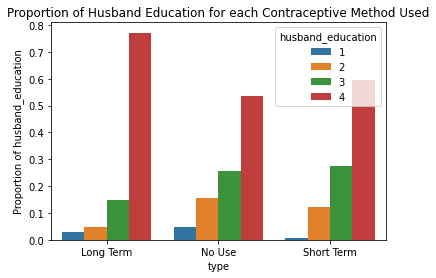

In [37]:
df = feature_percentage("husband_education")
sns.barplot(x = "type", y = "Proportion of husband_education",  hue = "husband_education", data = df)
plt.title("Proportion of Husband Education for each Contraceptive Method Used")

Text(0.5, 1.0, 'Proportion of Wife Education for each Contraceptive Method Used')

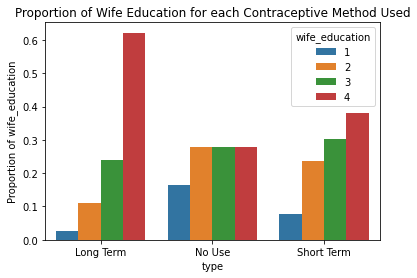

In [38]:
df = feature_percentage("wife_education")
sns.barplot(x = "type", y = "Proportion of wife_education",  hue = "wife_education", data = df)
plt.title("Proportion of Wife Education for each Contraceptive Method Used")

Text(0.5, 1.0, 'Standard of Living Proportions for each Contraceptive Method Used')

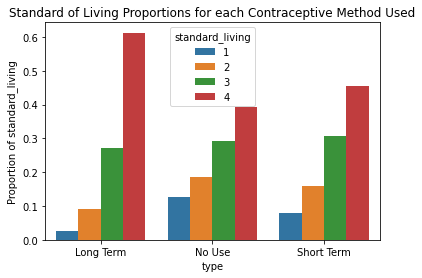

In [39]:
df = feature_percentage("standard_living")
sns.barplot(x = "type", y = "Proportion of standard_living",  hue = "standard_living", data = df)
plt.title("Standard of Living Proportions for each Contraceptive Method Used")

Standard of Living, Wife Edu, Husband Edu, all have very high percentages in the 'best' score for these long term, while short term is not as high. Maybe rich, more educated people tend to use birth
control more long term then short term, so even though the proportion of long term data is lower then short term, it may be easier to predict long term since so many of the long term ppl are so distincly educated and wealthy. This references the unexpected outcome of precision for short term vs long term. The no use was as expected, also was the highest proportion so the sheer amount of data likely overpowered the predictive power of long term. Note: This descrepancy occured in random forests but not in logistic regression.

#### 5. Split cleaned data into train and test data

*The data was split into 90% training data and 10% test data.*

In [40]:
X_train, X_test, y_train, y_test = train_test_split(design(contra, phi0), contra[['type']], test_size = .1, random_state = 42)

# Model 1. Logistic Regression

In [43]:
logistic_model = LogisticRegressionCV(multi_class = 'auto', random_state=42)
logistic_model.fit(X_train, y_train)
y_hat = logistic_model.predict(X_train)

##### Avergage Validation Accuracy

In [44]:
cross_val_avg = np.mean(cross_val_score(logistic_model, X_train, y_train))
print("Final Training Accuracy:", accuracy_score(y_hat, y_train))
print("Final Validation Accuacy:", cross_val_avg)

Final Training Accuracy: 0.5154716981132076
Final Validation Accuacy: 0.5079245283018868


##### Precision vs Recall vs Accuracy of Test Data

In [23]:
logistic_model.fit(X_train, y_train)
y_hat_test = logistic_model.predict(X_test)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

   Long Term       0.56      0.29      0.38        35
      No Use       0.63      0.68      0.65        69
  Short Term       0.42      0.52      0.46        44

    accuracy                           0.54       148
   macro avg       0.53      0.50      0.50       148
weighted avg       0.55      0.54      0.53       148



In [24]:
y_hat_test = logistic_model.predict(X_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_hat_test))

Final Test Accuracy: 0.5405405405405406


*A confusion matrix measures the performance of an machine learning algorithm. Each row of the confusion matrix represents the instances of an actual class and each column represents the instances of a predicted class.*

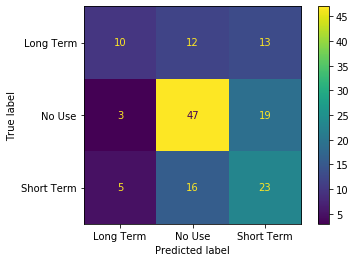

In [25]:
plot_confusion_matrix(logistic_model, X_test, y_test)

*Below are common functions used by decison tree and random forest*

In [26]:
"""
Returns a naive simple decision tree or random forest classifier
"""
def simple_model(model_name):
    train_acc, val_acc, test_acc = 0,0,0
    if model_name == 'decision tree':
        model = DecisionTreeClassifier(random_state = 10)
    elif model_name == 'random forest':
        model = RandomForestClassifier(random_state = 10)
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = np.mean(cross_val_score(model, X_train, y_train))
    test_acc = accuracy_score(y_test, y_hat_test)
    return train_acc, val_acc, test_acc

In [27]:
"""
Plots the training vs validation accuracy for feature being tuned.
"""
def plot_graph(train_accuracy, val_accuracies, x_axis, name):
    plt.plot(x_axis, train_accuracy, label = "Training Accuracy")
    plt.plot(x_axis, val_accuracies, label = "Validation Accuracy")
    plt.legend(loc='best')
    if name == "Feature Functions":
        plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    plt.title("Training & Validation Accuracy vs {}".format(name))
    plt.xlabel(name)

In [28]:
"""
Returns training and validation accuracy of the model for different max depth value
"""
def max_depth_tuning(model_name, max_depth, best_n_estimator = 1000):
    val_accuracies = []
    train_accuracies = []
    for d in max_depth:
        if model_name == 'decision tree':
            model = DecisionTreeClassifier(max_depth = d, random_state = 10)
        elif model_name == 'random forest':
            model = RandomForestClassifier(n_estimators = best_n_estimator, max_depth = d, random_state = 10)
        model.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(model, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

# Model 2. Decision Tree

### Attempt #1: Simple Naive model

In [29]:
train_acc, val_acc, test_acc = simple_model("decision tree")
print("Training Accuracy", train_acc)
print("Validation Accuracy", val_acc)

Training Accuracy 0.9471698113207547
Validation Accuracy 0.4777358490566038


### Attempt #2: Tuning max depth

We get the best validation accuracy at depth 4 with validation accuracy 0.5411320754716982


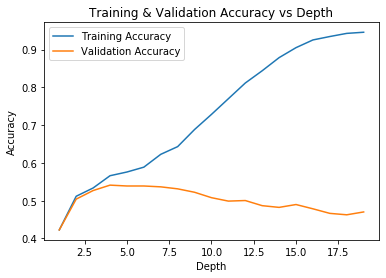

In [30]:
depth_range = np.arange(1,20)
train_acc, val_acc = max_depth_tuning("decision tree", depth_range)
plot_graph(train_acc,val_acc, depth_range, "Depth")
best_depth = depth_range[np.argmax(val_acc)]
print("We get the best validation accuracy at depth {} with validation accuracy {}".format(best_depth, max(val_acc)))

### Attempt #3: Tuning min sample split

*Based on our previous result, we achieve the maximum validation accuracy at depth 4*

*We will fix depth to be 4 in the following min sample split feature tuning*

In [31]:
min_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
def min_sample_tuning(min_splits):
    val_accuracies = []
    train_accuracies = []
    for s in min_splits:
        dt= DecisionTreeClassifier(min_samples_split= s ,max_depth = 4 , random_state = 10)
        dt.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, dt.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(dt, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

We get the best validation accuracy with 0.1 min samples split fraction and with validation accuracy 0.5426415094339623


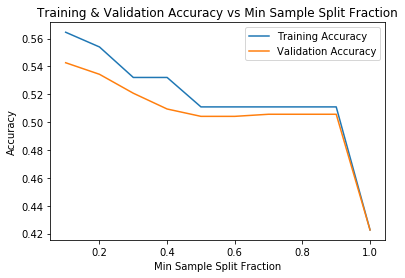

In [32]:
train_acc, val_acc = min_sample_tuning(min_splits)
plot_graph(train_acc, val_acc, min_splits, "Min Sample Split Fraction")
best_split = min_splits[np.argmax(val_acc)]
print("We get the best validation accuracy with {} min samples split fraction and with validation accuracy {}" \
      .format(best_split, max(val_acc)))

*As we can see, upon tuning the max_feature parameter, our model validation accuracy slightly improved to 0.542*

*In conclusion, using a single a decision tree does not provide good prediction results due to high Variance. One way to solve this is to consider a random forest which relies on randomized decision trees on random subsamples. Random Forest relies on the concept of taking the majority of votes when it comes to prediction which should be expected to reduce variance.*

# Model 3. Random Forest

### Attempt #1: Simple Naive model

In [33]:
train_acc, val_acc, test_acc = simple_model("random forest")
print("Training Accuracy", train_acc)
print("Validation Accuracy", val_acc)

Training Accuracy 0.9471698113207547
Validation Accuracy 0.5162264150943396


*Our simple model for random forest achieved 0.5162 average validation accuracy which was much higher than the simple model of decision trees!*

### Attempt #2:  Tuning number of trees

In [34]:
def num_trees_tuning(n_estimators):
    val_accuracies, train_accuracies = [], []
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators = n, bootstrap = True, random_state = 10)
        rf.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, rf.predict(X_train)))
        cross_val_avg = np.mean(cross_val_score(rf, X_train, y_train))
        val_accuracies.append(cross_val_avg)
    return train_accuracies, val_accuracies

We get the best validation accuracy with 560 number of trees and  with validation accuracy 0.5230188679245283


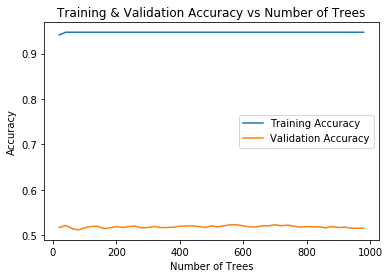

In [35]:
n_estimators = np.arange(20,1000, 20)
train_acc, val_acc = num_trees_tuning(n_estimators)
plot_graph(train_acc, val_acc, n_estimators, 'Number of Trees')
best_num = n_estimators[np.argmax(val_acc)]
print("We get the best validation accuracy with {} number of trees and  with validation accuracy {}".format(best_num, max(val_acc)))

### Attempt #3: Max Depth Tuning

*Based on our previous result, we achieve the maximum validation accuracy at 560 decision trees*

*We will fix n_estimators at 560 in the following max depth tuning*

We get the best validation accuracy at depth 9 with validation accuracy 0.5539622641509434


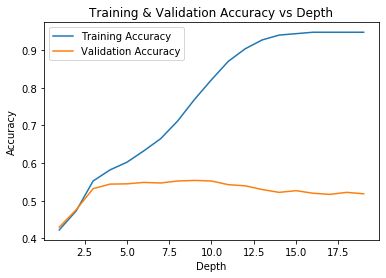

In [36]:
depth_range = np.arange(1,20)
train_acc, val_acc = max_depth_tuning("random forest", depth_range, 560)
plot_graph(train_acc,val_acc, depth_range, "Depth")
best_depth = depth_range[np.argmax(val_acc)]
print("We get the best validation accuracy at depth {} with validation accuracy {}".format(best_depth, max(val_acc)))

*After max depth tuning, we achieved our best validation accuracy so far at 0.5539.* 

*This was achieved with 560 trees and max depth 9*

### Attempt #4: Mixed Hyperparameter Tuning

*RandomSearchCV does not work properly with string class values. Thus,
the class values were temporarily converted to their original float values.*

In [37]:
X_train_f, X_test_f, y_train_f, y_test_f = \
    train_test_split(design(contra, phi0), contra[['contraceptive']], test_size = .1, random_state = 42)

#### 1. Random Parameter Grid

In [38]:
#number of trees in random forest
n_estimators = np.arange(100, 400, 20)

#depth of the tree
max_depth = np.arange(1,20)

#random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

In [39]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier(random_state = 10)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 18, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_f, y_train_f)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    6.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [40]:
rf_random.best_params_

{'n_estimators': 240, 'max_depth': 6}

#### 2. Grid Search

In [41]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,5,6],
    'n_estimators': [110,120,130]
}


In [42]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state = 10)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_f, y_train_f)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=10,
                                  

In [43]:
grid_search.best_params_

{'max_depth': 6, 'n_estimators': 110}

#### 3. Design the model based on the optimal parameters found

In [44]:
rf_best = RandomForestClassifier(n_estimators=110, max_depth = 6, random_state=10)

In [45]:
cross_val_avg = np.mean(cross_val_score(rf_best, X_train, y_train))

In [46]:
print("Random Forest Cross Val Score for attempt #4")
cross_val_avg

Random Forest Cross Val Score for attempt #4


0.5524528301886792

## More Feature Engineering

*Now we will try lifting the continuous variables to 
a new feature using various transformations*

In [47]:
def phi1(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        
    return X

def phi2(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        
    return X

def phi3(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        
    return X

def phi4(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        X[column + "^4"] = X[column]**4
        
    return X

def phi5(X, columns):

    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['tanh(' + column + ')'] = np.tanh(X[column])
        X[column + "^2"] = X[column]**2
        X[column + "^3"] = X[column]**3
        X[column + "^4"] = X[column]**4
        X[column + "^5"] = X[column]**5
        
    return X

def phi_ellipsoid(X, columns):
    
    for i in columns:
        X[i] = standardize(X[[i]])[i]
        for j in columns:
            if i == j:
                X[i + "^2"] = X[i]**2
            else:
                X[i + " * " + j] = X[i] * X[j]
    return X
                
def parabaloid(X, columns):
    
    for column in columns:
        X[column] = standardize(X[[column]])[column]
        X['norm^2_of_' + column] = np.linalg.norm(X[column])**2
        
    return X

feature_funcs = [phi0, phi1, phi2, phi3, phi4, phi5, phi_ellipsoid, parabaloid]



In [48]:
val_acc, train_acc = [], []
func_names = ['phi0', 'phi1', 'phi2', 'phi3', 'phi4', 'phi5', 'phi_ellipsoid', 'parabaloid']
for phi in feature_funcs:
    X_train, X_test, y_train, y_test = \
        train_test_split(design(contra, phi), contra[['type']], test_size = .1, random_state = 42)
    rf_best.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf_best.predict(X_train)))
    cross_val_avg = np.mean(cross_val_score(rf_best, X_train, y_train))
    val_acc.append(cross_val_avg)

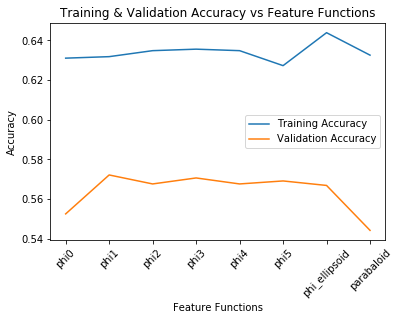

In [49]:
plot_graph(train_acc, val_acc, func_names, "Feature Functions")

In [50]:
print("The best performing feature function was {}".format(func_names[np.argmax(val_acc)]))

The best performing feature function was phi1


In [51]:
val_acc

[0.5524528301886792,
 0.5720754716981132,
 0.5675471698113207,
 0.570566037735849,
 0.5675471698113207,
 0.5690566037735849,
 0.5667924528301886,
 0.5441509433962264]

In [52]:
X_train, X_test, y_train, y_test = \
        train_test_split(design(contra, phi1), contra[['type']], test_size = .1, random_state = 42)
rf_best.fit(X_train, y_train)
y_hat_train = rf_best.predict(X_train)


*Confusion Matrix for the best Random Forest Algorithm using the best feature function phi1*

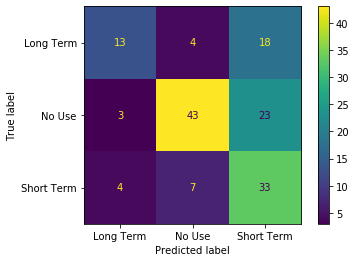

In [53]:
plot_confusion_matrix(rf_best, X_test, y_test)

In [54]:
print("Training Accuracy:", accuracy_score(y_train, y_hat_train))
print("Validation Accuracy:", np.mean(cross_val_score(rf_best, X_train, y_train)))

Training Accuracy: 0.6316981132075472
Validation Accuracy: 0.5720754716981132


*As a final check, religion was added as a feature to see how it would perform.*

In [55]:
X_train_religion, X_test_religion, y_train_religion, y_test_religion = \
    train_test_split(design_with_religion(contra, phi1), contra[['type']], test_size = .1, random_state = 42)

In [56]:
cross_val_avg_religion = np.mean(cross_val_score(rf_best, X_train_religion, y_train_religion))

In [57]:
cross_val_avg_religion

0.5577358490566038

*Adding religion as a feature performed worse, as expected*

*After utilizing Random Search and Grid Search to tune our hyperparameters, 
we concluded that using 110 trees, a max depth of 6, the default minimum samples 
split, and feature function phi1 (without religion) optimized our accuracy of our random forest model.*

In [58]:
y_hat_test = rf_best.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_hat_test))

Test Accuracy: 0.6013513513513513


In [59]:
report = classification_report(y_test, y_hat_test)
print(report)

              precision    recall  f1-score   support

   Long Term       0.65      0.37      0.47        35
      No Use       0.80      0.62      0.70        69
  Short Term       0.45      0.75      0.56        44

    accuracy                           0.60       148
   macro avg       0.63      0.58      0.58       148
weighted avg       0.66      0.60      0.60       148



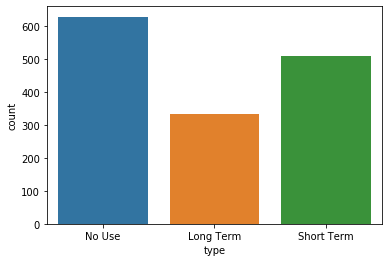

In [60]:
sns.countplot(data=contra, x = 'type')

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ 

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ 

*It was fishy to me that there was more data in the 'Short Term' 
class then the 'Long Term' yet there was higher precision in the 'Short Term'
class then the 'Long Term'. Analyzing the proportions of certain
features such as wife_education, husband_education, and standard_living showed that
there was a disproportionate amoung of rich and highly educated people that were 
on Long Term contraceptives vs Short Term. This likely made the predictive power
of these features much more profound for Long Term vs Short Term, which
would explain why the predictions were more precise, despite the algorithm seeing
less examples for the long term class*

*I realized that much of the 'No Use' and 'Short Term' birth control
results had similar proportion in' terms of the features husband education, 
wife education, and standard of living, but that Long Term Use was distinctly 
full of 'super smart rich' people. I decided to combine 'No Use' and 'Short Term'
into a single class assigned to 0 and Long Term Use assigned to class 1, making 
this a binary classification problem. The results on prediction improved significantly.*


# Testing the Models on the Binary Problem: Long Term vs No Use/Short Term

In [61]:
contra['type2'] = contra['contraceptive'].replace({1: 0, 2: 1, 3 : 0})

In [62]:
X_train_2class, X_test_2class, y_train_2class, y_test_2class = \
    train_test_split(design(contra, phi1), contra[['type2']], test_size = .3, random_state = 42)

X_test_2class, X_valid_2class, y_test_2class, y_valid_2class = \
    train_test_split(X_test_2class, y_test_2class, test_size = .5, random_state = 42)

In [63]:
logistic_model = LogisticRegressionCV(max_iter = 1000, random_state=42)
logistic_model.fit(X_train_2class, y_train_2class)
y_hat = logistic_model.predict(X_train_2class)

In [64]:
cross_val_avg = np.mean(cross_val_score(logistic_model, X_train_2class, y_train_2class))
print("Validation Accuracy Best Logistic Regression:", cross_val_avg)

Validation Accuracy Best Logistic Regression: 0.7701233525632005


In [65]:
y_hat_valid = logistic_model.predict(X_test_2class)

In [66]:
cross_val_avg = np.mean(cross_val_score(rf_best, X_train_2class, y_train_2class))

In [67]:
print("Validation Average Best Random Forest:", cross_val_avg)

Validation Average Best Random Forest: 0.7885558838703626


In [68]:
rf_best.fit(X_train_2class, y_train_2class)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [69]:
report = classification_report(y_valid_2class, y_hat_valid)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       172
           1       0.25      0.02      0.04        49

    accuracy                           0.77       221
   macro avg       0.51      0.50      0.45       221
weighted avg       0.66      0.77      0.68       221



Text(0.5, 1.0, 'Number of Samples for 2 Class Problem')

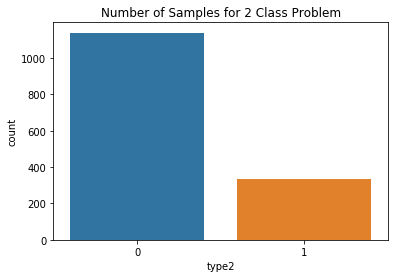

In [70]:
sns.countplot(data=contra, x = 'type2')
plt.title("Number of Samples for 2 Class Problem")


*It appears that transforming the three class problem into a 2 class
problem had very high precision and recall for class 0. However, 
the recall was very low for class 1. This is likely due to the fact the data had a heavily
disproportionate amount of 0 classes vs 1.*

# Final Metrics

*These metrics are calculated on the unbalanced data using a random forest model with 110 learners
and a maximum depth of 6 with feature function phi1 applied to the data and religion left out as a feature*

In [79]:
y_hat_train = rf_best.predict(X_train_2class)
rf_train_score = accuracy_score(y_hat_train, y_train_2class)
print("Train Accuracy Best Random Forest:", rf_train_score)

Train Accuracy Best Random Forest: 0.7749757516973812


In [80]:
y_hat_test = rf_best.predict(X_test_2class)
rf_test_score = accuracy_score(y_hat_test, y_test_2class)
print("Test Accuracy Best Random Forest:", rf_test_score)

Test Accuracy Best Random Forest: 0.7375565610859729
